---
---
*<h1 align='center'> Xception ML models on Plant_Pathology_2020 - dataset </h1>*

---
---
Name: Logesh.V <br>
Email: vlogesh2001@gmail.com <br>
DATASET: https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data

### **Importing required packages**

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import os
from tqdm import tqdm # to get progress bars while running
import cv2
from sklearn.utils import shuffle

from tensorflow import keras
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.compat.v1.disable_eager_execution()

import warnings
warnings.filterwarnings('ignore')

### **Data Loading and Pre-Processing**

In [2]:
# this CSV contains classition properties of the resp input images file names
data = pd.read_csv("plant-pathology/train.csv", index_col=0)

# CLASSES
class_names = list(data.columns)
np.save('class_names',class_names) # save array
print(class_names)

print(data.shape)
data.head()

['healthy', 'multiple_diseases', 'rust', 'scab']
(1821, 4)


healthy  multiple_diseases  rust  scab
image_id                                        
Train_0         0                  0     0     1
Train_1         0                  1     0     0
Train_2         1                  0     0     0
Train_3         0                  0     1     0
Train_4         1                  0     0     0

In [3]:
# getClasses function is used to get the class value for our class key
def Class_Label(n):
    '''Returns label no. if file_name is given and integer decoding'''
    # given a file name - return interger name
    if ((type(n)==str) and ('.' in n)):
        row = data.loc[n.split('.')[0]]
        for x,i in enumerate(class_names):
            if (row[i] == 1): 
                return x
    # given a class name - return interger label
    elif ((type(n)==str) and (n in class_names)):
        return class_names.index(n)
    # given a integer label - return class name
    elif (n in range(len(class_names))):
        return class_names[n]
    else:
        return -1

#### *Primary preprocessing transformations*
- Normalizing and standardizing the images.
- Resizing of the images to 229x229. The Inception network input expects a 229x229 image. </br>
`This will be implemented in CV2 as computation cost is individually very high implementing through numpy`

In [4]:
# We use the load data function to read our data folders and label each of the images with 
# folder name and append them to a list which is then converted to an array
# labeled for supervised/unsupervised data flag
def Load_Data(folders, file_prefix, dim, labeled = True):
    '''To import the dataset from the directories and preprocess them'''
        
    # final outputs:
    images=[]
    labels=[]
    
    # iterate through folders
    for folder in folders:
        
        # iterate through each image in folder
        for file in tqdm(os.listdir(folder)):   
            
            if (file.startswith(file_prefix)):
                
                # get pathname of each image
                img_path = os.path.join(folder, file)
               
                # Open and pre-process it
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # so we are converting to RGB format
                image = cv2.resize(image, (dim[0], dim[1])) # resizing
                image = image/255 # normalization
                #print(image.shape)
                #print(image)
                #print("\n\n")
                # Append the image and its corresponding label to the output
                images.append(image)
                if (labeled):
                    label = Class_Label(file)
                    labels.append(label)
                
    print("Folder-Loaded:",folder,"-->",file_prefix,"over.")
                
    # Converting the data type of the list
    images = np.array(images, dtype = 'float32') # images in float
    labels = np.array(labels, dtype = 'int8') #labels in integer encoded
    
    if (labeled):
        # Shuffling the order of data for better accuracy and a good data split
        images,labels = shuffle(images,labels,random_state=random.randint(0, 10))
        
    if (labeled):
        return images, labels
    else:
        return images

In [5]:
# Default Image Size for all data
image_size = (299,299)

# Loading Data - Train-Test images
train_images, train_labels = Load_Data(["plant-pathology/images"], 'Train', image_size)
test_images = Load_Data(["plant-pathology/images"], 'Test', image_size, False)

100%|██████████████████████████████████████████████████████████████████████████████| 3642/3642 [00:53<00:00, 67.83it/s]


Folder-Loaded: plant-pathology/images --> Train over.


100%|██████████████████████████████████████████████████████████████████████████████| 3642/3642 [00:53<00:00, 68.65it/s]


Folder-Loaded: plant-pathology/images --> Test over.


### **Data Visualization**

Shape of Test Data : (1821, 299, 299, 3)
Shape of Train Data : (1821, 299, 299, 3)
 Labels and their count :
 Counter({2: 622, 3: 592, 0: 516, 1: 91})


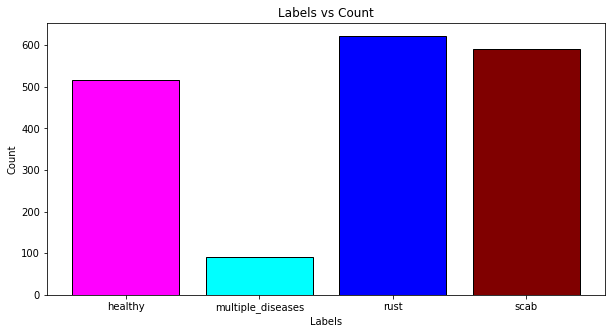

In [6]:
print(f'Shape of Test Data : {test_images.shape}')
print(f'Shape of Train Data : {train_images.shape}')

from collections import Counter
label_count = Counter(train_labels)
print(f' Labels and their count :\n {label_count}')

x = list(label_count.keys())
y = list(label_count.values())

fig = plt.figure(figsize = (10,5))
plt.bar(x,y,color=['cyan','blue','magenta','maroon'],  edgecolor='black')
plt.title('Labels vs Count')
plt.xticks([0,1,2,3],class_names)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [7]:
def dis_rand_exp(images, labels, x=4, y=5):
    fig = plt.figure(figsize = (21,17))
    fig.suptitle("Random Examples of Data-Set images", fontsize=32)
    for i in range(x*y):
        plt.subplot(x,y,i+1)
        plt.xticks([])
        plt.yticks([])
        rand = random.randint(0,len(images))
        plt.imshow(images[rand], cmap='gray')
        plt.xlabel(Class_Label(labels[rand]), fontsize=18)
    plt.show()

In [8]:
from sklearn.model_selection import train_test_split
# Spliting validation data from train data as test data is unclassified
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=.15)

Training data size: (1547, 299, 299, 3)
Test data size: (1821, 299, 299, 3)
Validation data size: (274, 299, 299, 3)

Ploting Test Dataset


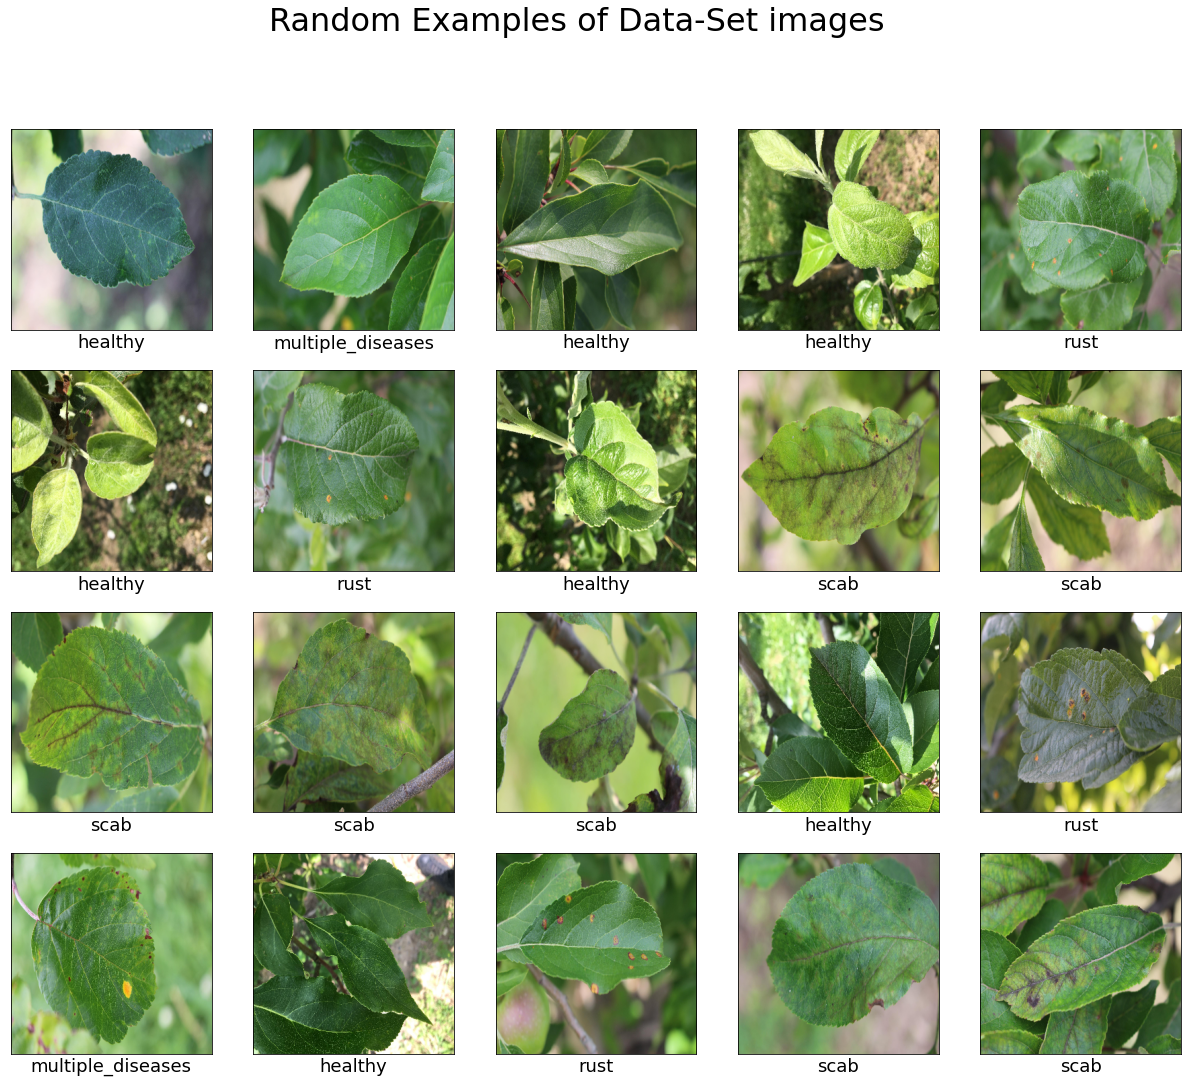

In [9]:
print("Training data size:", train_images.shape)
print("Test data size:", test_images.shape)
print("Validation data size:", val_images.shape)
print("\nPloting Test Dataset")
dis_rand_exp(train_images, train_labels)

---
*<h1 align='center'> Deep Learning Models </h1>*

---

## XCEPTION Classifier - Model Implementation

#### *Using Xception (Inbuilt)*
- `weights='imagenet'` : Pre-trained ImageNet weights are loaded for transfer learning.
- `include_top=False` : We do not include the fully-connected head with the softmax classifier. In other words, we chop off the head of the network.
- `pooling='avg'` : avg means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.

#### *CATEGORICAL CROSS-ENTROPHY MODELING --> this model training gives Out-Of-Memory error for GPU*

#### *SPARSE-CATEGORICAL CROSS-ENTROPHY MODELING --> For Classification*
- SGD (Stochastic gradient descent) --> Gradient descent is the preferred way to optimize neural networks and many other machine learning algorithms but is often used as a black box. This post explores how many of the most popular gradient-based optimization algorithms such as Momentum, Adagrad, and Adam actually work.
- lr (learning Rate)

In [10]:
# For Classification (no.of features = no.of classes)
model = keras.models.Sequential([
    keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', input_shape=(image_size[0],image_size[1],3)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1024),
    keras.layers.LeakyReLU(alpha=0.05),
    keras.layers.Dense(512),
    keras.layers.LeakyReLU(alpha=0.05),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

# Compling our Model
model.compile(optimizer=tf.optimizers.SGD(lr=0.0075),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model._name="Xception_Classifier"
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "Xception_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________

## Training and Results
`tf.keras.backend.clear_session` --> If you are creating many models in a loop, this global state will consume an increasing amount of memory over time, and you may want to clear it. Calling clear_session() releases the global state: this helps avoid clutter from old models and layers, especially when memory is limited.

In [11]:
#Stop training when a monitored metric (here, accuracy) has stopped improving.
#patience: Number of epochs with no improvement after which training will be stopped.
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)

# Saving the best Trained model
model_file = model.name+'_Model.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_file, save_best_only=True)

tf.keras.backend.clear_session
history = model.fit(train_images,
                    train_labels,
                    epochs=15, # Max no.of epochs
                    #steps_per_epoch=100,
                    batch_size=16, # size for parallel computation, higher require more GPU/CPU-RAM
                    validation_freq=1,
                    validation_data=(val_images,val_labels),
                    callbacks=[early_stopping_cb, checkpoint_cb]
                   )

Train on 1547 samples, validate on 274 samples
Epoch 1/15
1547/1547 [==============================] - 86s 56ms/sample - loss: 1.2312 - accuracy: 0.4337 - val_loss: 1.1290 - val_accuracy: 0.6642
Epoch 2/15
1547/1547 [==============================] - 78s 50ms/sample - loss: 1.0285 - accuracy: 0.6315 - val_loss: 0.7664 - val_accuracy: 0.6788
Epoch 3/15
1547/1547 [==============================] - 80s 51ms/sample - loss: 0.6914 - accuracy: 0.7867 - val_loss: 0.4280 - val_accuracy: 0.8905
Epoch 4/15
1547/1547 [==============================] - 80s 52ms/sample - loss: 0.4401 - accuracy: 0.8630 - val_loss: 0.3222 - val_accuracy: 0.9051
Epoch 5/15
1547/1547 [==============================] - 81s 52ms/sample - loss: 0.3289 - accuracy: 0.8914 - val_loss: 0.2815 - val_accuracy: 0.8978
Epoch 6/15
1547/1547 [==============================] - 82s 53ms/sample - loss: 0.2641 - accuracy: 0.9089 - val_loss: 0.2655 - val_accuracy: 0.9161
Epoch 7/15
1547/1547 [==============================] - 82s 53ms/

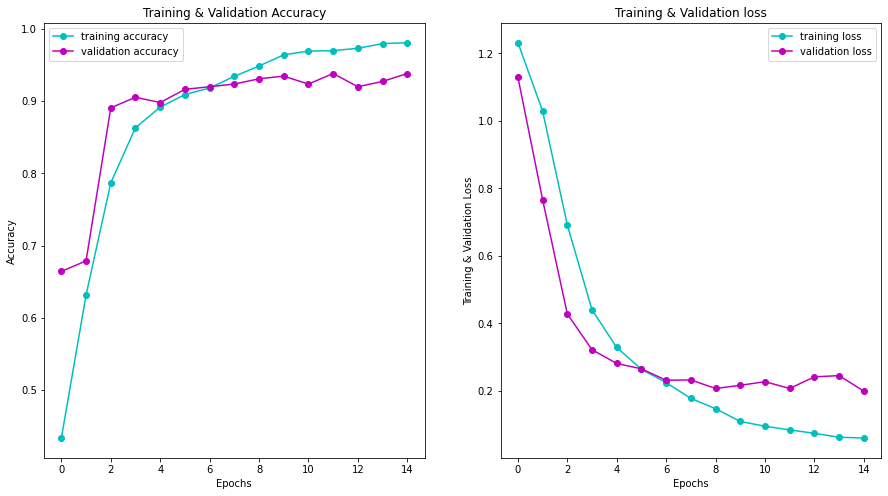

In [12]:
def plot_accuracy_and_loss_of_train_and_validation_dataset(history):
    train_acc=history.history['accuracy']
    train_loss=history.history['loss']
    val_acc=history.history['val_accuracy']
    val_loss=history.history['val_loss']
    epoch=[i for i in range(len(train_acc))]
    fig , ax=plt.subplots(1,2)
    fig.set_size_inches(15,8)
    ax[0].plot(epoch,train_acc,'co-',label='training accuracy')
    ax[0].plot(epoch,val_acc,'mo-',label='validation accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epoch,train_loss,'c-o',label='training loss')
    ax[1].plot(epoch,val_loss,'m-o',label='validation loss')
    ax[1].set_title('Training & Validation loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")

# incase of early stop
plot_accuracy_and_loss_of_train_and_validation_dataset(history)

## Evaluation

In [13]:
# loading the saved model of Xception Classifier
model_file = 'Xception_Classifier_Model.h5'
model = keras.models.load_model(model_file) # rollback to best model
loss,accuracy = model.evaluate(train_images,train_labels)
print("The accuracy of train image is : ",accuracy)

The accuracy of train image is :  0.9993536


### Accuracy for each class

In [14]:
print("Predicting Validation Images using the above Trained model...(as test data is unlabeled)")
pred_Ids_of_test = model.predict(val_images)

Predicting Validation Images using the above Trained model...(as test data is unlabeled)


In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predIdxs = np.argmax(pred_Ids_of_test, axis=1) # to get the indices of max value in each row
print(classification_report(val_labels, predIdxs,target_names=class_names))

                   precision    recall  f1-score   support

          healthy       0.90      0.96      0.93        75
multiple_diseases       1.00      0.40      0.57        10
             rust       0.96      0.98      0.97        97
             scab       0.95      0.93      0.94        92

         accuracy                           0.94       274
        macro avg       0.95      0.82      0.85       274
     weighted avg       0.94      0.94      0.93       274



### Confusion Matrix

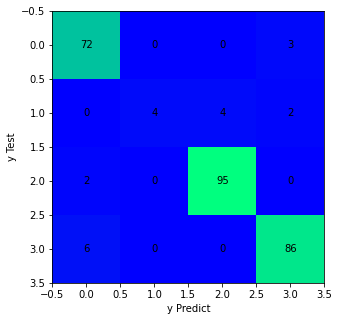

In [16]:
CM = confusion_matrix(val_labels, predIdxs)
# Plot confusion matrix
plt.figure(figsize = (5,5))
plt.imshow(CM,interpolation='nearest',cmap='winter')
for (i, j), z in np.ndenumerate(CM):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y Test")
plt.grid(False)
plt.show()

### *Evaluating UNLABELED test data & and saving the output for comparing with ML-Classifiers*

In [17]:
test_set = pd.read_csv("plant-pathology/test.csv") # Reading resp test-images file-names
test_pred = model.predict(test_images, batch_size=10)
df_pred = pd.concat([test_set, pd.DataFrame(test_pred, columns=class_names)], axis=1).set_index("image_id")
df_pred.to_csv("plant-pathology/xception_results.csv") # saving prediction test-images in each class into a .csv file
print(df_pred.idxmax(axis=1))
df_pred

image_id
Test_0                    rust
Test_1       multiple_diseases
Test_2                    rust
Test_3                    scab
Test_4                    rust
                   ...        
Test_1816                 rust
Test_1817                 rust
Test_1818    multiple_diseases
Test_1819                 rust
Test_1820                 rust
Length: 1821, dtype: object


healthy  multiple_diseases      rust          scab
image_id                                                      
Test_0     0.000116           0.008431  0.991435  1.675743e-05
Test_1     0.001240           0.577844  0.399109  2.180635e-02
Test_2     0.000143           0.005438  0.994413  6.388027e-06
Test_3     0.000042           0.001817  0.000002  9.981385e-01
Test_4     0.000069           0.002426  0.997500  5.172933e-06
...             ...                ...       ...           ...
Test_1816  0.004923           0.483562  0.507017  4.497981e-03
Test_1817  0.000082           0.017652  0.982248  1.819622e-05
Test_1818  0.025252           0.368451  0.321432  2.848656e-01
Test_1819  0.000071           0.002054  0.997870  4.576247e-06
Test_1820  0.000004           0.000228  0.999767  1.275505e-07

[1821 rows x 4 columns]

Test-Labels: [2 1 2 ... 1 2 2]

Ploting Test Dataset


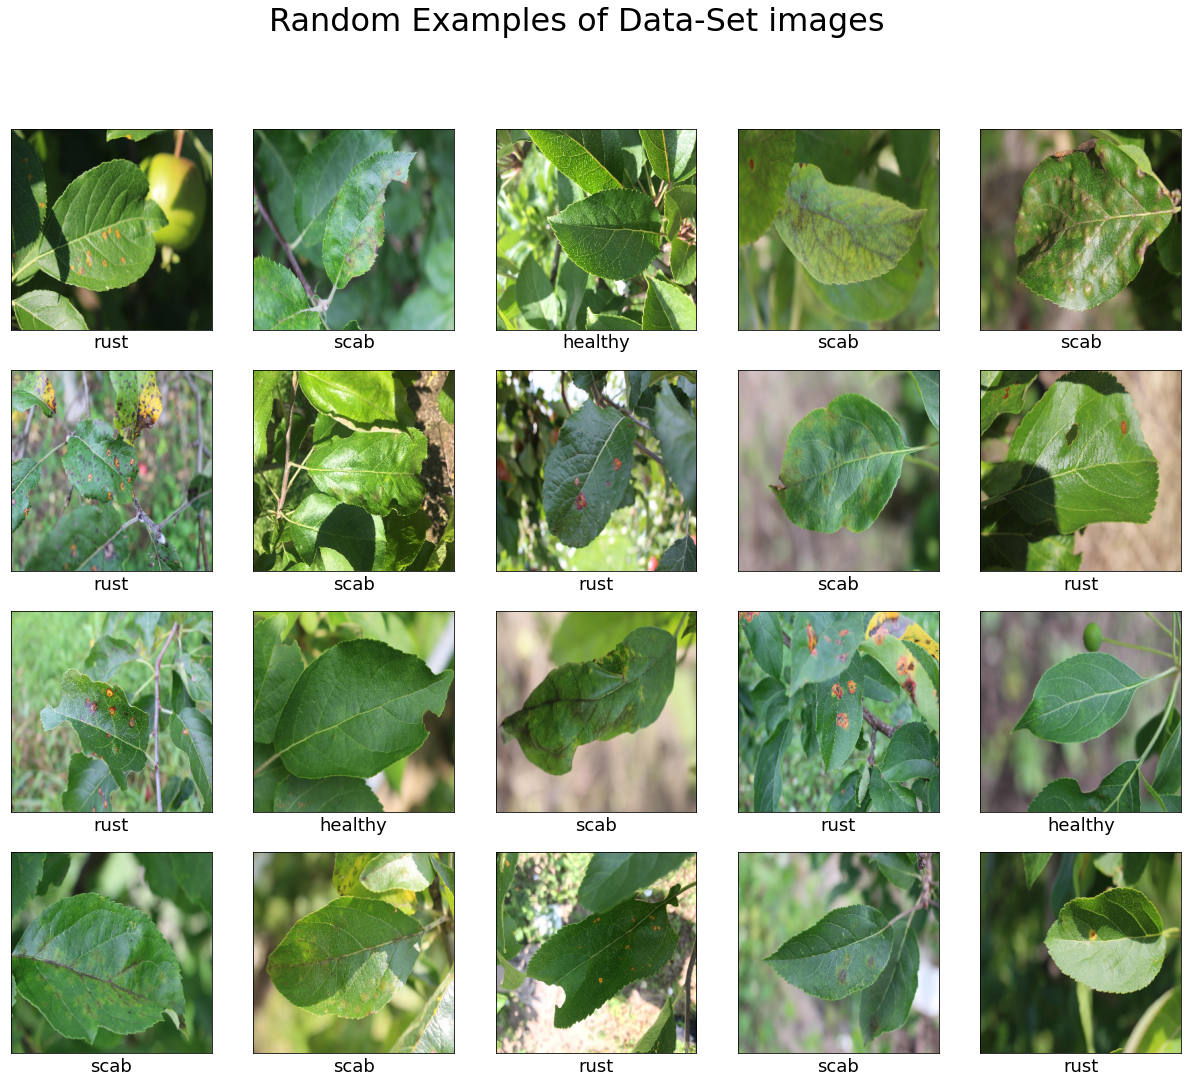

In [18]:
# Creating test labels for evaluating standard performance measures on upcoming ML classifiers
df_pred.columns = np.arange(len(df_pred.columns))
test_labels = np.array(df_pred.idxmax(axis=1),'int8')
print("Test-Labels:",test_labels)

#Saving Train-Test-Valid Datasets
np.savez_compressed('pre-processed-datasets',train_images,train_labels,test_images,test_labels,val_images,val_labels)

print("\nPloting Test Dataset")
dis_rand_exp(test_images, test_labels)

 ---
*<h1 align='center'>Transfer Learning into ML Classifiers</h1>*

---

### Importing required packages

In [1]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.compat.v1.disable_eager_execution()

import warnings
warnings.filterwarnings('ignore')

## XCEPTION Feature Extractor - using Pre-Trained Classifier

In [2]:
# loading class-names
class_names = np.load('class_names.npy')

# loading Pre-Processed Data-Sets
train_images,train_labels,test_images,test_labels,val_images,val_labels = np.load('pre-processed-datasets.npz')

# we no longer need validation data, so we combine it with train data
with np.load('pre-processed-datasets.npz') as data:
    train_images = np.concatenate((data[train_images],data[val_images]),axis=0)
    train_labels = np.concatenate((data[train_labels],data[val_labels]),axis=0)
    test_images = data[test_images]
    test_labels = data[test_labels]
print("Training data size:", train_images.shape)
print("Test data size:", test_images.shape)

# loading the saved model of Inception Classifier
model_file = 'Xception_Classifier_Model.h5'
model = keras.models.load_model(model_file)

print("\n\nPrinting layers of Model -",model.name,":")
for layer in model.layers:
    print(layer)

print("\nFeature extraction from the model:")
feature_layer = model.get_layer('xception')
print(feature_layer)

Training data size: (1821, 299, 299, 3)
Test data size: (1821, 299, 299, 3)
Instructions for updating:
Colocations handled automatically by placer.


Printing layers of Model - Xception_Classifier :

Feature extraction from the model:


#### *Alternative method to create our own model upto feature-layer as model-output and re-train* </br> 
For Sparse Feature extraction:</br>
`feature_model = keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', input_shape= image_size[0],image_size[1],3))`

Xception Model Architecture


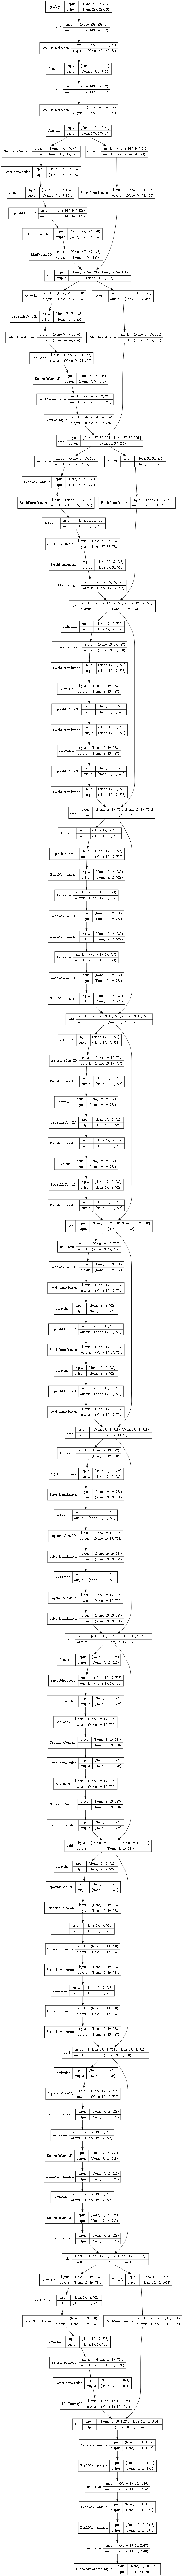

In [3]:
feature_model = keras.Model(inputs = feature_layer.inputs, outputs = feature_layer.outputs)
feature_model._name="Xception_Feature_Extractor"

# Showing Xception Model Architecture
print("Xception Model Architecture")
keras.utils.plot_model(feature_model,'Xception.png',show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True, dpi=75)
# rankdir='TB' -> top to bottom
#feature_model.summary()

### **Extracting the deep features of our Dataset**
*(i.e., model **without** Fully-Connected-Layers[DNN] for Feature-Extracting))*

In [4]:
train_features = feature_model.predict(train_images)
test_features = feature_model.predict(test_images)
print("Training data size:", train_features.shape)
print("Test data size:", test_features.shape)

Training data size: (1821, 2048)
Test data size: (1821, 2048)


### *Searching for the best model*
These above features-data is given as inputs for ML-Classifiers and best out them is found

In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# keep no.of classifiers even for plottinf purposes
classifiers = [LogisticRegression(), LGBMClassifier(device = "gpu"), GaussianNB(), DecisionTreeClassifier(),
               RandomForestClassifier(), KNeighborsClassifier(), SVC(kernel='linear'), GradientBoostingClassifier()]

#### *Fitting and Ploting results*



Classifier: LogisticRegression()
Accuracy  is 95.93629873695771%, Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       406
           1       0.64      0.70      0.67        74
           2       0.98      0.97      0.97       738
           3       0.97      0.97      0.97       603

    accuracy                           0.96      1821
   macro avg       0.89      0.90      0.90      1821
weighted avg       0.96      0.96      0.96      1821



Classifier: LGBMClassifier(device='gpu')
Accuracy  is 93.73970345963755%, Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       406
           1       0.73      0.43      0.54        74
           2       0.96      0.98      0.97       738
           3       0.95      0.94      0.95       603

    accuracy                           0.94      1821
   macro avg       0.88      0.82      0.85      1821
weighted avg       0.93  

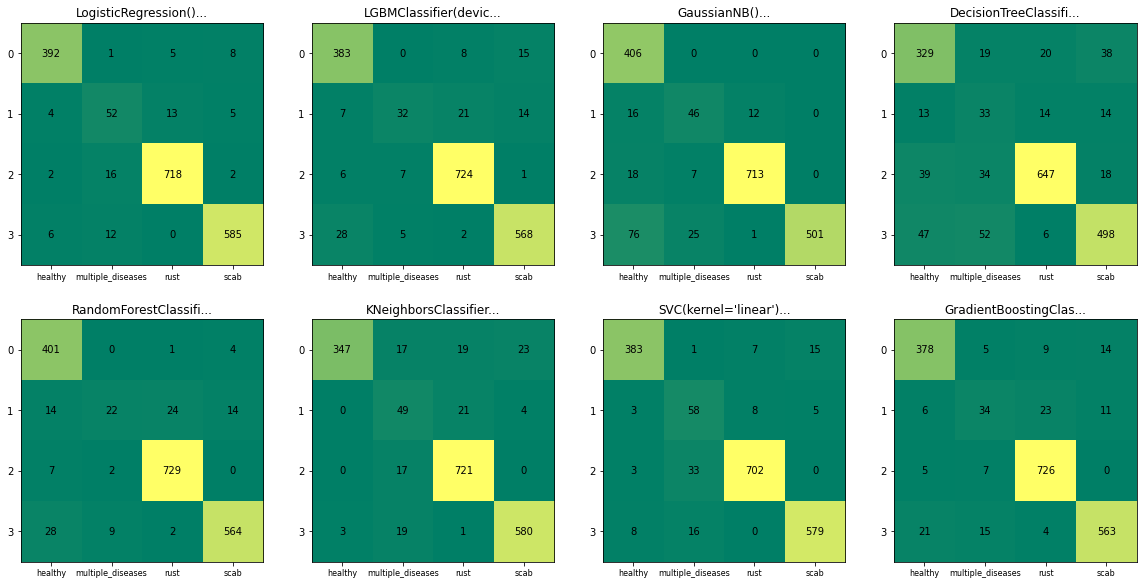

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

fig = plt.figure(figsize=(20,10))
fig.tight_layout()
nof_clsfrs = len(classifiers)
Accuracies = {}


for i in range(nof_clsfrs):
    tf.keras.backend.clear_session
    classifier = classifiers[i]
    plt.subplot(2,nof_clsfrs/2,i+1)
    plt.xticks([])
    plt.yticks([])
    
    print(f'\n\nClassifier: {str(classifier)}')
    classifier.fit(train_features, train_labels)
    test_pred = classifier.predict(test_features)
    
    acc = accuracy_score(test_labels,test_pred) *100
    Accuracies[str(classifier)[0:20]+'...'] = acc
    print(f'Accuracy  is {acc}%, Report:')
    print(classification_report(test_labels, test_pred))
    
    plt.gca().set_title(str(classifier)[0:20]+'...')
    CM = confusion_matrix(test_labels, test_pred)
    plt.imshow(CM,interpolation='nearest',cmap='summer')
    for (i, j), z in np.ndenumerate(CM):
        plt.text(j, i, z, ha='center', va='center')
    plt.xticks(np.arange(len(class_names)),class_names, fontsize=8)
    plt.yticks(np.arange(len(class_names)))
    plt.grid(False)
plt.show()

*`These standard performance measures of test_data in these ML models are compared based on the labels predicted by the Deep-Learning Xception-Classifier model, as test-labels are obtained from DL-model only`*

In [7]:
import pandas as pd
result = pd.DataFrame({'Classifier':list(Accuracies.keys()),
                 'Accuracy':list(Accuracies.values())})
print("Results:")
print(result)
print("\n\nClassifier for which max Accuracy is obtained:")
print(result.iloc[result["Accuracy"].idxmax()])

Results:
                Classifier   Accuracy
0  LogisticRegression()...  95.936299
1  LGBMClassifier(devic...  93.739703
2          GaussianNB()...  91.488193
3  DecisionTreeClassifi...  82.756727
4  RandomForestClassifi...  94.233937
5  KNeighborsClassifier...  93.190555
6  SVC(kernel='linear')...  94.563427
7  GradientBoostingClas...  93.410214


Classifier for which max Accuracy is obtained:
Classifier    LogisticRegression()...
Accuracy                    95.936299
Name: 0, dtype: object


---
#### *<div style="text-align: center"> - - - - - Thank You - - - - - <div>*
---